In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

random_seed = 42
torch.manual_seed(random_seed)

In [2]:
import torchvision
from torchinfo import summary

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_base_12 = torchvision.models.vit_b_16(weights=vit_weights)

# Print a summary
summary(model=vit_base_12, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [3]:
vit_transforms = vit_weights.transforms()

data_dir = '../EuroSAT/2750'
eurosat_dataset = datasets.ImageFolder(data_dir, transform=vit_transforms)
eurosat_dataset
# Split the data into train and test sets while preserving the original split

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ../EuroSAT/2750
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [4]:
from torch.utils.data import DataLoader, random_split

#split into 80,10,10
total_size = len(eurosat_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoader instances for train, validation, and test sets
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

In [5]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


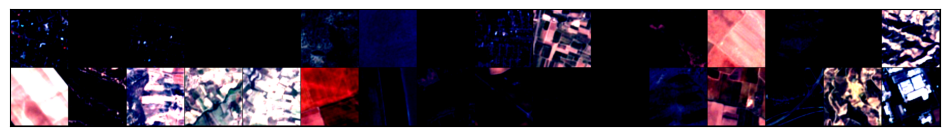

In [6]:
show_batch(train_loader)

In [7]:
# Define the ResNet-18 model
class EuroSAT_ViTBase12(nn.Module):
    def __init__(self):
        super(EuroSAT_ViTBase12, self).__init__()
        self.eurosat = vit_base_12  # Initialize ResNet-18 without pretrained weights
        self.eurosat.heads = nn.Linear(768, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.eurosat(x)

model = EuroSAT_ViTBase12()

# Loss and optimizer

In [8]:
model

EuroSAT_ViTBase12(
  (eurosat): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [10]:
model = model.to(device)

In [11]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

In [12]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Evaluation On Train dataset:

In [14]:
correct = 0
total = 0
total_loss = 0.0
with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(train_loader)
accuracy = 100 * correct / total

In [15]:
print("Train accuracy: ",accuracy,"%", " Train Loss: ",avg_loss)

Train accuracy:  13.555555555555555 %  Train Loss:  2.334724246484262


# Evaluation On Validation dataset:

In [16]:
correct = 0
total = 0
total_loss = 0.0
with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(val_loader)
accuracy = 100 * correct / total

In [17]:
print("Validation accuracy: ",accuracy,"%", " Validation Loss: ",avg_loss)

Validation accuracy:  15.222222222222221 %  Validation Loss:  2.3174972423287326


# Evaluation On Test dataset:

In [18]:
correct = 0
total = 0
total_loss = 0.0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(test_loader)
accuracy = 100 * correct / total

In [19]:
print("Test accuracy: ",accuracy,"%", " Test Loss: ",avg_loss)

Test accuracy:  13.925925925925926 %  Test Loss:  2.322940604631291
